## Определение перспективного тарифа для аренды самокатов
Имеются данные из сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки  
абонентская плата отсутствует;  
стоимость одной минуты поездки — 8 рублей;  
стоимость старта (начала поездки) — 50 рублей;  

с подпиской Ultra  
абонентская плата — 199 рублей в месяц;  
стоимость одной минуты поездки — 6 рублей;  
стоимость старта — бесплатно.  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
print('таблица users:')
display(users.head())
print('\n', 'таблица rides:')
display(rides.head())
print('\n', 'таблица subscriptions')
display(subscriptions)
print('\n')
print('инфо об users:', '\n', users.info())
print('инфо об rides:', '\n', rides.info())
print('инфо об subscribers:', '\n', subscriptions.info())

таблица users:


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



 таблица rides:


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



 таблица subscriptions


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
инфо об users: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
инфо об rides: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0

По первичному знакомству с данными можно сказать, что в них нет пропусков в значениях, таблицы можно было бы обьеденить в одну

столбцы проименованны корректно, кроме стоблца date типы данных верны

#### Шаг 2. Предобработка данных

In [3]:
rides['date'] = pd.to_datetime(rides['date'])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [4]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
display(rides.head())
print('Данные имеются в периоде с:', rides['date'].min(), 'по:', rides['date'].max())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Данные имеются в периоде с: 2021-01-01 00:00:00 по: 2021-12-30 00:00:00


In [5]:
print(users.duplicated().sum())
print(rides.duplicated().sum())
print(users['city'].unique())
users = users.drop_duplicates().reset_index()
users.duplicated().sum()

31
0
['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']


0

По итогам предобработке данных в таблице users столбец date был приведен к формату datetime, был добавлен столбец month с индексом месяца каждой поездки и были удалены явные дубликаты в таблице users, в остальных таблицах не было найдено

#### Шаг 3. Исследовательский анализ данных

In [6]:
cities = users['city'].value_counts()
subscriptions_counts = users['subscription_type'].value_counts()
ages = users['age'].value_counts()

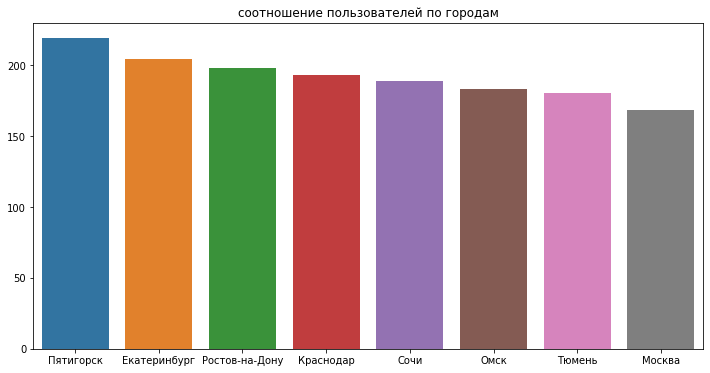

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(y=cities.values, x=cities.index)
# plt.axis('equal')
plt.title('соотношение пользователей по городам')
plt.show()

По данным графикам видно, что больше всего пользователей в Пятигорске, далее количество плавно спадает в порядке: Екатеринбург, Ростов-на-дону, Краснодар, Сочи, Омск, Тюмень, и меньше всего пользователей в Москве

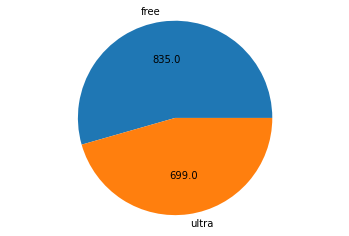

In [8]:
def absolute_value(val):
    a  = np.round(val/100.*subscriptions_counts.values.sum(), 0)
    return a

plt.pie(subscriptions_counts.values, labels=subscriptions_counts.index,
        autopct=absolute_value)

plt.axis('equal')
plt.show()


Пользователей без подписки 835 и без нее почти 700, разница в почти 5%

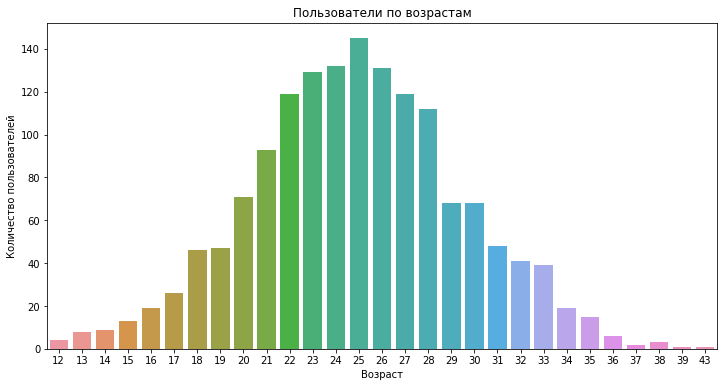

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x=ages.index, y=ages.values)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Пользователи по возрастам')
plt.show()

График возраста пользователей напоминает нормальное распределение и больше всего пользователей в возрасте от 21 до 28, также стоит отметить что пользуются сервисом и несовершеннолетние

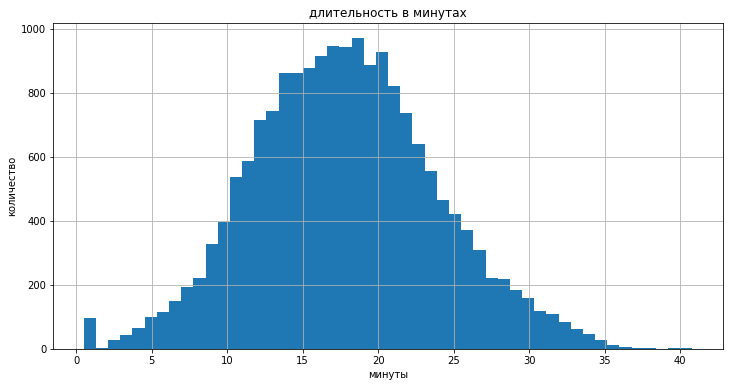

In [10]:
plt.figure(figsize=(12, 6))
rides['duration'].hist(bins=50)
plt.xlabel('минуты')
plt.ylabel('количество')
plt.title('длительность в минутах')
plt.show()

График длительности поездки напоминает нормальное распределение и больше всего поездок от 12 до 22 минут, также стоит отметить выброс с 0.5 минутами, в этом случае вероятно случился же баг системы или какая то запланированная акция

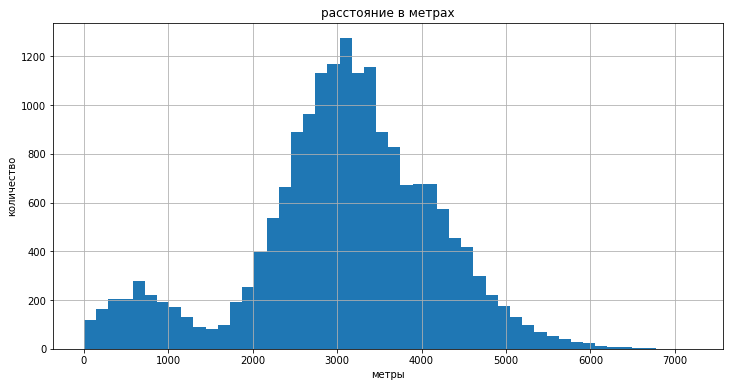

In [11]:
plt.figure(figsize=(12, 6))
rides['distance'].hist(bins=50)
plt.xlabel('метры')
plt.ylabel('количество')
plt.title('расстояние в метрах')
plt.show()

График расстояния поездки напоминает 2 нормальных распределения вместе, где первое значительно меньше, первый пик в районе 800м и второй в районе 3000м

In [12]:
rides.query('duration < 1').head()

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


Вероятно два пика на графике дистанций поездок обусловлены тем, что самокаты берут на либо на короткие расстояния (от метро до дома или работы) или на длинные просто чтобы покататься для удовольствия, либо на расстоянии от 1000м до 2000м выгоднее воспользоваться общественным транспортом

#### Шаг 4. Объединение данных

In [14]:
data = users.merge(rides, on='user_id')
data = data.merge(subscriptions, on='subscription_type')
data.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [15]:
yes_subscribers = data[data['subscription_type'] == 'ultra']
non_subscribers = data[data['subscription_type'] == 'free']
display(non_subscribers.head())
display(yes_subscribers.head())

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,699,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,699,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,699,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,699,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,699,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


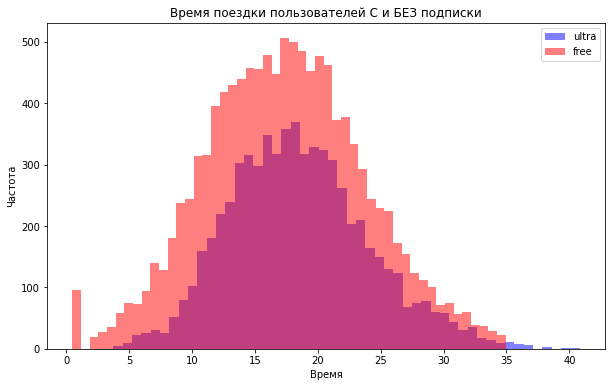

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(yes_subscribers['duration'], color='blue', alpha=0.5, label='ultra', bins=50)
plt.hist(non_subscribers['duration'], color='red', alpha=0.5, label='free', bins=50)

plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Время поездки пользователей С и БЕЗ подписки')
plt.legend()

plt.show()

По графику как будто бы можно сказать что клиенты с подпиской в прицнипе меньше катаются, как будто бы непропорционально меньше, чем 5%, но характер распределения то же

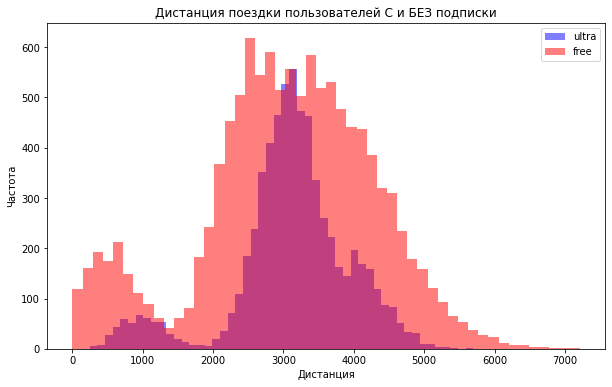

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(yes_subscribers['distance'], color='blue', alpha=0.5, label='ultra', bins=50)
plt.hist(non_subscribers['distance'], color='red', alpha=0.5, label='free', bins=50)

plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.title('Дистанция поездки пользователей С и БЕЗ подписки')
plt.legend()

plt.show()

По графику видно, что по первому пику без подписки чаще берут на меньшую дистанцию, чем пользователи с подпиской  
А по второму пику видно, что дисперсия пользователей с подпиской сильно меньше, чем без нее, но пик в том же месте

Заметно, что графики С и БЕЗ подписок похожи, однако похоже что стандартное отклонение у пользователей без подписки немного выше

#### Шаг 5. Подсчёт выручки

In [18]:
data['duration'] = np.ceil(data['duration'])
data

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1533,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1533,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1533,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1533,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [19]:
data['revenue_per_ride'] = data.query('subscription_type == "free"')['duration'] \
* data.query('subscription_type == "free"')['minute_price'] + data.query('subscription_type == "free"')['start_ride_price']

summered_data = data.groupby(['user_id', 'month', 'subscription_type']).agg(
    revenue=('revenue_per_ride', 'sum'),
    duration=('duration', 'sum'),
    count=('duration', 'count')
).reset_index()



data.loc[data['subscription_type'] == 'ultra', 'revenue_per_ride2'] = data['duration'] * data['minute_price']
summered_data.loc[summered_data['subscription_type'] == 'ultra', 'revenue'] = data.query('subscription_type == "ultra"')['subscription_fee'] +  summered_data.query('subscription_type == "ultra"')['duration'] * data.query('subscription_type == "ultra"')['minute_price']

data



summered_data
data

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,revenue_per_ride,revenue_per_ride2
0,0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199,NaN,156.0
1,0,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199,NaN,96.0
2,0,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199,NaN,42.0
3,0,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199,NaN,114.0
4,0,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199,NaN,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1533,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0,210.0,NaN
18064,1533,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0,226.0,NaN
18065,1533,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0,202.0,NaN
18066,1533,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0,186.0,NaN


#### Шаг 6. Проверка гипотез


Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза: пользователи с подпиской и без тратят одинаковое время на поездки   
Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки  

In [21]:
alpha = 0.05
results = st.ttest_ind(yes_subscribers['duration'], non_subscribers['duration'], alternative='greater')
print('pvalue:', results.pvalue)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('НЕ отвергаем нулевую гипотезу')
    
print(
    '\n'
    'active subscribers mean duration:', yes_subscribers['duration'].mean(), '\n'
    'non subscribers mean duration:', non_subscribers['duration'].mean(),
    
)

pvalue: 1.2804098316645618e-34
отвергаем нулевую гипотезу

active subscribers mean duration: 18.54198516280583 
non subscribers mean duration: 17.39090929866399


По итогу проверки гипотезы можно сказать, что пользователи с подпиской в среднем тратят больше времени на поездки


Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза: пользователи с подпиской проезжают за одну поездку 3130 метров    
Альтернативная гипотеза: пользователи с подпиской проезжают за одну поезду больше 3130 метров

In [22]:
alpha = 0.05
results = st.ttest_1samp(yes_subscribers['distance'], 3130, alternative='greater')
print('pvalue:', results.pvalue)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('НЕ отвергаем нулевую гипотезу')

pvalue: 0.9195368847849785
НЕ отвергаем нулевую гипотезу


Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров


Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.  

Нулевая гипотеза: пользователи с подпиской приносят такую же выручку в месяц, что и без подписки
Альтернативная гипотеза: пользователи с подпиской приносят больше выручки, нежели пользователи без подписки

In [23]:
alpha = 0.05
results = st.ttest_ind(
    summered_data.query('subscription_type=="ultra"')['revenue'],
    summered_data.query('subscription_type=="free"')['revenue'], alternative='greater'
)
print('pvalue:', results.pvalue)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('НЕ отвергаем нулевую гипотезу')
    
    
print(
    '\n'
    'active subscribers mean revenue by month:', summered_data.query('subscription_type=="ultra"')['revenue'].mean(), '\n'
    'non subscribers mean revenue by month:', summered_data.query('subscription_type=="free"')['revenue'].mean(),
)

pvalue: 1.8850394384715216e-31
отвергаем нулевую гипотезу

active subscribers mean revenue by month: 362.7921906022502 
non subscribers mean revenue by month: 328.6413651073845


Помесячная выручка от пользователей с подпиской выше, чем без


Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

в такой ситуации понадобится тест для зависимых выборок  
для подсчета пригодится метод  
`st.ttest_rel(data_before, data_after, alternative='greater')`

#### Шаг 7. Распределения

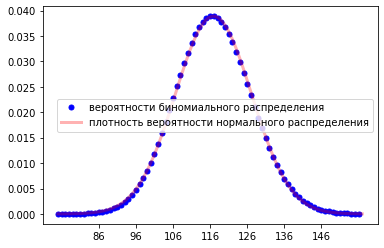

0.04971489312694162

In [24]:
n = 1169
p = 0.1
mu = n*p
sigma = sqrt((n*p*(1-p)))
distr = st.norm(mu, sigma)
 
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()

# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 10))
ax.set_xticks(x_ticks)
ax.legend(loc='best')
plt.show()
distr.cdf(100)

Чтобы шанс, что после подарочного месяца возобновило подписку меньше 100 людей, был 5% нужно раздать 1169 промокодов

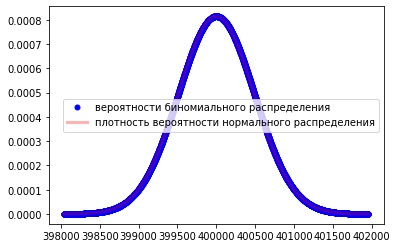

0.15371708296369768

In [26]:
n = 1000000
p = 0.4
mu = n*p
sigma = sqrt((n*p*(1-p)))
distr = st.norm(mu, sigma)

 
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)


# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()
distr.cdf(399500)

вероятность того, что уведомление откроют не более 399,5 тыс. пользователей примерно равна 15.37%

### Общий вывод

**Краткий обзор проведенной работы.**  
Были удалены дубликаты  
Проведен анализ времени в поездке, расстоянии, количества пользователей, и возраста клиентов с и без подписки  
Вычислена прибыл, которую принесла каждая поездка и был сделан анализ по прибыли для клиентов с и без подписки  
Были проверены гипотезы относительно пользователей с и без подписки: кто больше приносит прибыли, больше тратит времени на поездки, и ездят ли пользователи с подпиской больше 3130м за проездку  


**Главные выводы.**
Пользователи с подпиской являются более выгодными для компании, они дольше ездят на самокатах, приносят больше прибыли, чем пользователи без подписок  
Типичный пользователь это клиент от 21 до 28 лет  
Типичная поездка от 12 до 22 минут  


**Рекомендации.**
Чтобы не было дубликатов и пропусков значений стоит проверить програмное обеспечение на наличие багов, и исправность работы геолокации